## 总体思路
### 读取与预处理数据

目标变量：CREDIT_SCORE

特征工程：对 R_EXPENDITURE 加平方项；

对 CAT_GAMBLING 做 One-Hot 编码；选取若干特征，

用 statsmodels 的 OLS 进行回归；

输出 model.summary()。

### 八种可视化方法

残差图（Residual Plot）

相关矩阵（Correlation Heatmap）

系数权重图（Weight Plot）

整体效应图（Effect Plot）

均值效应图（Mean Effect Plot, 可视作特征重要性）

个体效应图（Individual Effect Plot）

效应趋势图（Effect Trend Plot）

SHAP 可视化（通用解释方法，也可用于非线性模型）

### 这 8 种可视化大体分为两类：

整体（Global） 方法（如残差图、相关矩阵、系数权重、整体效应、均值效应、效应趋势图），帮助理解模型对所有样本的整体表现及特征对目标的平均影响。

局部（Local） 方法（如个体效应图、SHAP waterfall plot 等），可以针对某个单个样本解释为什么预测值高/低。

In [ ]:
pip install kagglehub

In [1]:
pip install statsmodels


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("conorsully1/credit-score")

print("Path to dataset files:", path)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/codespace/.cache/kagglehub/datasets/conorsully1/credit-score/versions/1


### 1. 读取数据，构建模型

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# 如果需要 SHAP:
# import shap

##############################################################################
# 1. 读取数据与特征工程
##############################################################################

df = pd.read_csv("/home/codespace/.cache/kagglehub/datasets/conorsully1/credit-score/versions/1/credit_score.csv")  # 替换为你的实际数据路径

# 目标变量
y = df['CREDIT_SCORE']

# 添加平方项，以捕捉 R_EXPENDITURE 的非线性关系
df['R_EXPENDITURE_SQR'] = df['R_EXPENDITURE']**2

# 选择主要特征（示例）
X = df[['INCOME',
        'R_DEBT_INCOME',
        'R_EXPENDITURE',
        'R_EXPENDITURE_SQR',
        'R_ENTERTAINMENT',
        'CAT_GAMBLING']].copy()

# One-hot 编码赌博特征
X['GAMBLING_LOW'] = (X['CAT_GAMBLING'] == 'Low').astype(int)
X['GAMBLING_HIGH'] = (X['CAT_GAMBLING'] == 'High').astype(int)
X.drop('CAT_GAMBLING', axis=1, inplace=True)

##############################################################################
# 2. 训练集 / 测试集划分
##############################################################################

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 对训练集加上截距
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

##############################################################################
# 3. 使用 statsmodels 进行 OLS 回归 (仅在训练集上)
##############################################################################

model = sm.OLS(y_train, X_train_sm).fit()
print(model.summary())

##############################################################################
# 4. 在测试集上预测
##############################################################################

y_pred = model.predict(X_test_sm)

test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {test_mse:.2f}, Test R²: {test_r2:.2f}")

                            OLS Regression Results                            
Dep. Variable:           CREDIT_SCORE   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     540.2
Date:                Thu, 06 Mar 2025   Prob (F-statistic):          1.59e-296
Time:                        10:33:12   Log-Likelihood:                -3754.0
No. Observations:                 800   AIC:                             7524.
Df Residuals:                     792   BIC:                             7561.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               671.7840     23.25

### Plot 1: 残差图（测试集）

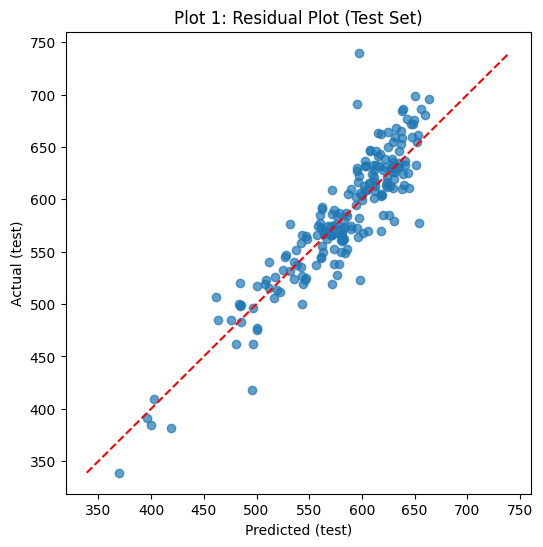

In [4]:
plt.figure(figsize=(6, 6))
plt.scatter(y_pred, y_test, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linestyle='--')
plt.xlabel("Predicted (test)")
plt.ylabel("Actual (test)")
plt.title("Plot 1: Residual Plot (Test Set)")
plt.show()

### Plot 2: 相关矩阵（基于训练集特征）

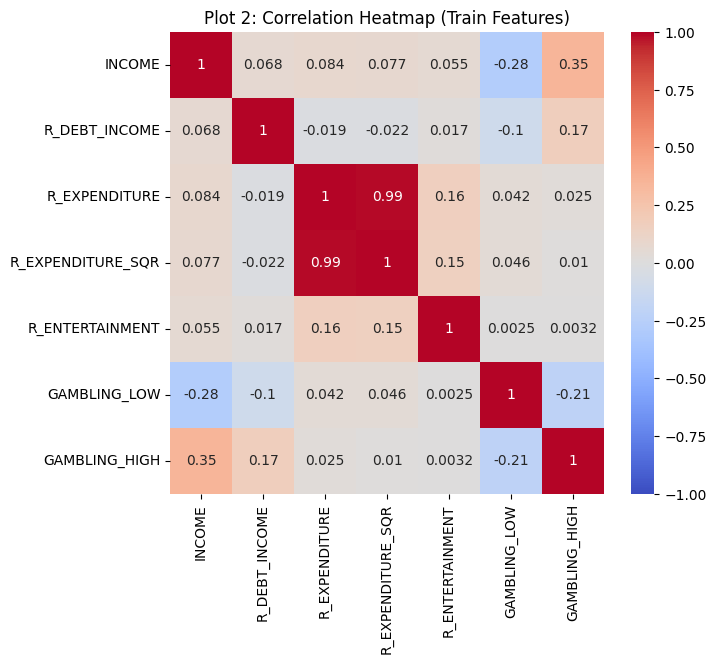

In [5]:
corr_matrix = X_train.corr()
plt.figure(figsize=(7, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, annot=True)
plt.title("Plot 2: Correlation Heatmap (Train Features)")
plt.show()

### plot 3 - 系数权重图 (训练好的模型)

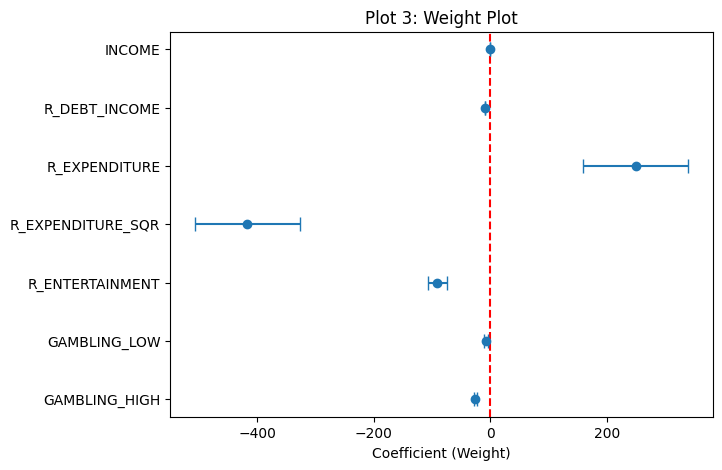

In [6]:
# 排除截距后获取系数与标准误
coefs = model.params[1:]
bse = model.bse[1:]
feat_names = X_train_sm.columns[1:]

# 反转顺序以便从上到下可视化
coefs = coefs[::-1]
bse = bse[::-1]
feat_names = feat_names[::-1]

plt.figure(figsize=(7, 5))
plt.axvline(x=0, color='red', linestyle='--')
plt.errorbar(coefs, feat_names, xerr=bse, fmt='o', capsize=5)
plt.xlabel("Coefficient (Weight)")
plt.title("Plot 3: Weight Plot")
plt.show()

- 准备特征效应 (训练集) 用于 Plot 4-7

- 也可结合测试集样本来做本地或全局可解释，但这里以训练集为主

In [7]:
# 计算每个样本上的系数贡献: X_train_sm * params
# 注意: statsmodels 的 params 包括 const，因此 shape 要对齐
train_effects = X_train_sm.mul(model.params, axis=1)

# 合并相关列
train_effects['R_EXPENDITURE'] = (train_effects['R_EXPENDITURE'] +
                                  train_effects['R_EXPENDITURE_SQR'])
train_effects['GAMBLING'] = (train_effects['GAMBLING_LOW'] +
                             train_effects['GAMBLING_HIGH'])

train_effects.drop(['R_EXPENDITURE_SQR',
                    'GAMBLING_LOW',
                    'GAMBLING_HIGH'], axis=1, inplace=True)


### Plot 4: 效应图 (Effect Plot, 全局 boxplot)

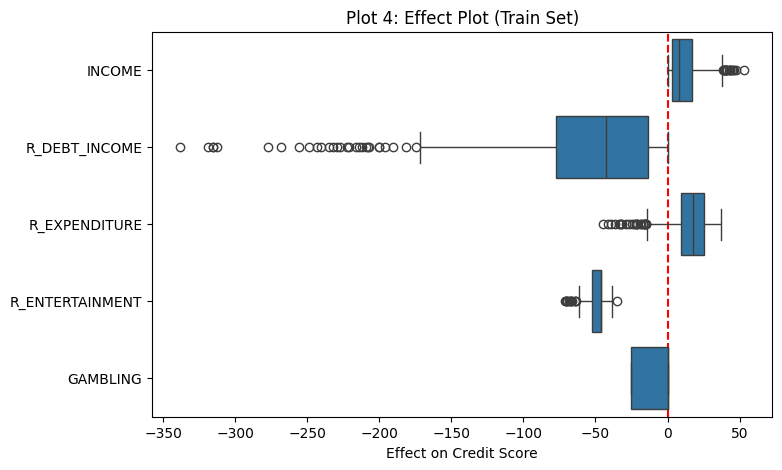

In [8]:
# 若不想将截距合并，可以把它保留不动；
# 若想"以截距为基准"重新对齐，可做 train_effects + intercept 之类的操作。
# 这里先演示简单版本：不合并截距

plt.figure(figsize=(8, 5))
plt.axvline(x=0, color='red', linestyle='--')
sns.boxplot(data=train_effects.drop(columns='const'), orient='h', color='tab:blue')
plt.xlabel("Effect on Credit Score")
plt.title("Plot 4: Effect Plot (Train Set)")
plt.show()

### Plot 5: 均值效应图 (Mean Effect Plot)

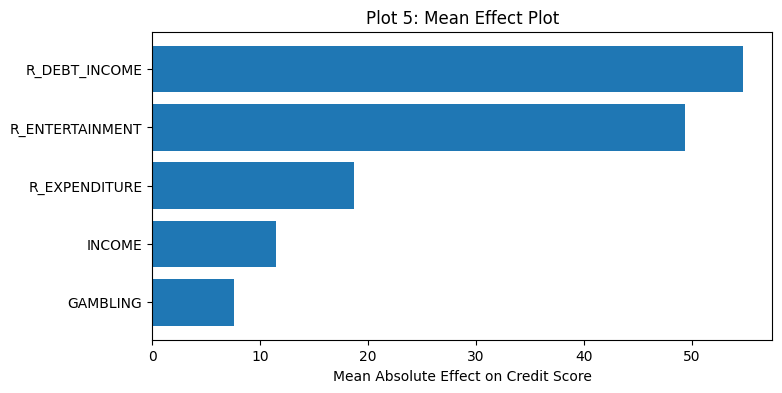

In [9]:
abs_effects = train_effects.drop(columns='const').abs()  # 取绝对值
mean_effects = abs_effects.mean(axis=0).sort_values()

plt.figure(figsize=(8, 4))
plt.barh(mean_effects.index, mean_effects)
plt.xlabel("Mean Absolute Effect on Credit Score")
plt.title("Plot 5: Mean Effect Plot")
plt.show()

### Plot 6: 个体效应图 (Individual Effect Plot)

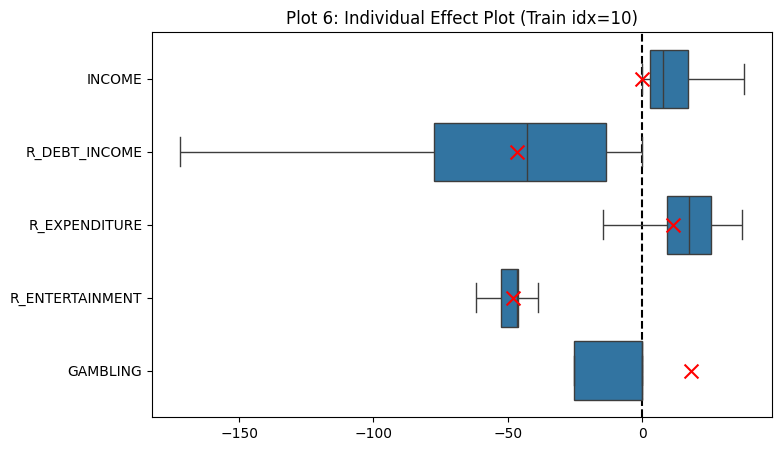

In [10]:

idx = 10  # 你可以改成任何训练集索引
individual = X_train_sm.iloc[idx] * model.params

# 合并同类项
ind_copy = individual.copy()
ind_copy['R_EXPENDITURE'] = ind_copy['R_EXPENDITURE'] + ind_copy['R_EXPENDITURE_SQR']
ind_copy['GAMBLING'] = ind_copy['GAMBLING_LOW'] + ind_copy['GAMBLING_HIGH']
ind_copy.drop(['R_EXPENDITURE_SQR',
               'GAMBLING_LOW',
               'GAMBLING_HIGH'], inplace=True)

plt.figure(figsize=(8, 5))
plt.axvline(x=0, color='black', linestyle='--')
sns.boxplot(data=train_effects.drop(columns='const'), orient='h', color='tab:blue', showfliers=False)

# 在箱线图上叠加该样本的贡献
features_eff = train_effects.drop(columns='const').columns
for i, feat in enumerate(features_eff[::-1]):
    # 反转顺序以匹配 boxplot 的顺序
    real_feat = features_eff[::-1][i]
    val = ind_copy[real_feat]
    plt.scatter(val, i, c='red', marker='x', s=100, zorder=10)

plt.title(f"Plot 6: Individual Effect Plot (Train idx={idx})")
plt.show()


### Plot 7: 效应趋势图 (Effect Trend Plot)

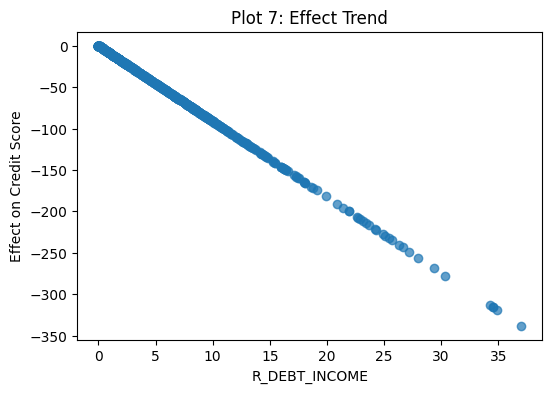

In [11]:
plt.figure(figsize=(6, 4))
plt.scatter(X_train['R_DEBT_INCOME'], 
            train_effects['R_DEBT_INCOME'], alpha=0.7)
plt.xlabel("R_DEBT_INCOME")
plt.ylabel("Effect on Credit Score")
plt.title("Plot 7: Effect Trend")
plt.show()

### Plot 8: SHAP (需要安装 shap)

对线性回归而言，SHAP 与我们手动计算的 Effect 类似

需要numpy版本低于2.1

In [1]:
# pip install shap

In [ ]:
# import shap
# explainer = shap.KernelExplainer(model.predict, X_train_sm)
# shap_values = explainer(X_train_sm, nsamples=100)  # 计算 SHAP
# shap.plots.waterfall(shap_values[0], show=False)   # 单个样本
# shap.plots.bar(shap_values)                        # 全局 bar 图